# Seattle Police Department Crime Data Analysis - Capstone Project

This notebook presents a comprehensive analysis of Seattle Police Department crime data to understand crime patterns, trends, and factors that influence criminal activity in Seattle.

## Project Overview

### Dataset Information
- **Source**: Seattle Police Department Crime Data (2008-Present) + US Census Demographics
- **Size**: 726K+ crime records with census tract demographics (2015-2025)
- **Format**: CSV with 40 variables including temporal, geographic, categorical, and demographic features
- **Coverage**: All reported crimes in Seattle with matched census demographics where available

### Research Objectives

This analysis aims to address key questions that can inform evidence-based crime prevention strategies:

#### 1. Predictions - Crime Volume Prediction
- **Question**: How many crimes will occur in this area next month?
- **Application**: Resource allocation, targeted patrol strategies, and proactive deployment based on predictive risk factors
- **Methodology**: Regression modeling using temporal, spatial, demographic, and environmental features

#### 2. Predictions - Crime Category Classification
- **Question**: What category does this crime belong to?
- **Application**: Automated crime classification and priority response systems
- **Methodology**: Multi-class classification using crime features to predict offense category

#### 3. Analysis - Geographic Crime Patterns (If time permits)
- **Question**: Where do crimes occur most frequently?
- **Application**: Optimize patrol scheduling, allocate community safety resources, and design location-specific crime prevention strategies
- **Methodology**: Seasonal crime trend analysis, and integration of census demographic data

### Expected Outcomes

**For Law Enforcement:**
- Data-driven patrol routing and scheduling optimization
- Predictive models for resource allocation
- Early warning systems for crime hotspots

**For Community Safety:**
- Risk assessment tools for residents and businesses
- Evidence-based crime prevention recommendations
- Transparency in public safety trends

**For Policy Makers:**
- Statistical insights for policy development
- Cost-effective intervention strategies
- Performance metrics for public safety initiatives

### Technical Approach

**Data Pipeline:**
1. **Data Loading & Validation** - Robust data ingestion with quality checks
2. **Exploratory Data Analysis** - Statistical summaries and pattern discovery
3. **Feature Engineering** - Creation of temporal, spatial, and categorical features
4. **Predictive Modeling** - Machine learning models for forecasting and classification
5. **Visualization & Reporting** - Interactive dashboards and analytical insights

---
**Let's begin by loading and exploring the Seattle crime data to understand patterns that can inform public safety decisions.**

In [1]:
# Core libraries
import re
import os
import warnings
import time
from datetime import datetime

# Data manipulation and analysis
import pandas as pd
import numpy as np
import scipy as sp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import (
    StandardScaler, LabelEncoder, OrdinalEncoder, 
    OneHotEncoder, PolynomialFeatures
)
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# Machine learning - models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

# Machine learning - pipeline and evaluation
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration
warnings.filterwarnings("ignore")
os.makedirs('images', exist_ok=True)
os.makedirs('images/all', exist_ok=True)
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 1. Data Loading and Initial Exploration

Let's start by loading the SPD Crime dataset enriched with census demographics and examining its structure.

In [2]:
# Load SPD Crime dataset with census demographics using the data loader library
print("Loading SPD Crime Data with Census Demographics...")

# Load the joined SPD Crime and Census dataset
orig_df = pd.read_csv("data/spd_census_joined.csv")

main_df = orig_df.copy()

Loading SPD Crime Data with Census Demographics...


In [3]:
# Rename columns to remove spaces and use underscores
print("Renaming columns to use underscores...")
print(f"Original columns: {len(main_df.columns)} columns")

# Create column mapping dictionary
column_mapping = {}
for col in main_df.columns:
    # First, replace spaces with underscores
    new_col = col.replace(' ', '_')
    
    # Handle camelCase by inserting underscores before capital letters
    # Insert underscore before capital letters that follow lowercase letters or numbers
    new_col = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', new_col)
    
    # Handle multiple consecutive spaces or special characters
    new_col = '_'.join(word for word in new_col.split('_') if word)
    
    # Convert to lowercase for consistency
    new_col = new_col.lower()
    
    column_mapping[col] = new_col

# Rename the columns
main_df = main_df.rename(columns=column_mapping)

print(f"Renamed columns: {len(main_df.columns)} columns")

# Only show changes if there are any
changed_columns = [(old, new) for old, new in column_mapping.items() if old != new]
if changed_columns:
    print(f"Changed {len(changed_columns)} column names:")
    for old_name, new_name in changed_columns:  # Show all changes
        print(f"  '{old_name}' -> '{new_name}'")
else:
    print("No column names needed changing")

num_cols = main_df.select_dtypes(include=[np.number]).columns
cat_cols = main_df.select_dtypes(exclude=[np.number]).columns
print(f"\nColumn Type Summary:")
print(f"  Numerical columns: {len(num_cols)}")
print(f"  Categorical columns: {len(cat_cols)}")

print(f"Final column count: {len(main_df.columns)}")

Renaming columns to use underscores...
Original columns: 51 columns
Renamed columns: 51 columns
Changed 46 column names:
  'Report Number' -> 'report_number'
  'Report DateTime' -> 'report_date_time'
  'Offense ID' -> 'offense_id'
  'Offense Date' -> 'offense_date'
  'NIBRS Group AB' -> 'nibrs_group_ab'
  'NIBRS Crime Against Category' -> 'nibrs_crime_against_category'
  'Offense Sub Category' -> 'offense_sub_category'
  'Shooting Type Group' -> 'shooting_type_group'
  'Block Address' -> 'block_address'
  'Latitude' -> 'latitude'
  'Longitude' -> 'longitude'
  'Beat' -> 'beat'
  'Precinct' -> 'precinct'
  'Sector' -> 'sector'
  'Neighborhood' -> 'neighborhood'
  'Reporting Area' -> 'reporting_area'
  'Offense Category' -> 'offense_category'
  'NIBRS Offense Code Description' -> 'nibrs_offense_code_description'
  'NIBRS_offense_code' -> 'nibrs_offense_code'
  'STATEFP' -> 'statefp'
  'COUNTYFP' -> 'countyfp'
  'TRACTCE' -> 'tractce'
  'GEOID_x' -> 'geoid_x'
  'NAME_x' -> 'name_x'
  'NAM

#### Feature Extraction

In this section, we perform comprehensive feature extraction and data preprocessing to prepare the Seattle Police Department crime data for analysis. This includes:

- Replace redacted values ('REDACTED', '-') with NaN for proper missing data handling
- Convert coordinate columns to numeric format and handle invalid coordinates (-1.0)
- Convert date strings to proper datetime objects for temporal analysis
- Extract granular time components: year, month, day, hour from both offense and report dates
- Create separate features for offense timing vs. reporting timing to capture delays
- Ensure numerical columns are properly typed for mathematical operations
- Maintain categorical variables as objects for encoding operations

In [4]:

# Convert all redacted values to null
main_df.replace(to_replace='REDACTED', value=np.nan, inplace=True)
main_df.replace(to_replace='-', value=np.nan, inplace=True)

# Convert coordinate columns to numeric (this will also handle -1.0 replacement better)
main_df['latitude'] = pd.to_numeric(main_df['latitude'], errors='coerce')
main_df['longitude'] = pd.to_numeric(main_df['longitude'], errors='coerce')

# Replace all placeholder values with NaN in one operation
main_df.replace(to_replace={
    'latitude': -1.0, 
    'longitude': -1.0, 
    'median_household_income': -666666666.0, 
    'median_home_value': -666666666.0, 
    'total_population': -666666666.0
}, value=np.nan, inplace=True)

# Convert date columns to datetime for filtering
main_df['offense_date'] = pd.to_datetime(main_df['offense_date'], errors='coerce')
main_df['report_date_time'] = pd.to_datetime(main_df['report_date_time'], errors='coerce')

# Extract year, month, day and time from the offense date time, report date time
main_df['offense_year'] = main_df['offense_date'].dt.year
main_df['offense_month'] = main_df['offense_date'].dt.month
main_df['offense_day'] = main_df['offense_date'].dt.day
main_df['offense_hour'] = main_df['report_date_time'].dt.hour
main_df['offense_weekday'] = main_df['offense_date'].dt.dayofweek

main_df['report_year'] = main_df['report_date_time'].dt.year
main_df['report_month'] = main_df['report_date_time'].dt.month
main_df['report_day'] = main_df['report_date_time'].dt.day
main_df['report_hour'] = main_df['report_date_time'].dt.hour

# Create year-month column
main_df["offense_year_month"] = pd.to_datetime({
    'year': main_df['offense_year'],
    'month': main_df['offense_month'], 
    'day': 1
}, errors='coerce')

# Data types summary
print(f"\nData Types:")
type_counts = main_df.dtypes.value_counts()
for dtype, count in type_counts.items():
    print(f"   {dtype}: {count} columns")

print(f"\n" + "="*60)
print(f"DETAILED COLUMN ANALYSIS")
print(f"="*60)

# Quick stats for numerical columns
numerical_cols = main_df.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 0:
    print(f"\nNumerical columns ({len(numerical_cols)}):")
    for col in numerical_cols:
            print(f"   - {col}:")
            print(f"     Count: {main_df[col].count():,}")
            print(f"     Unique: {main_df[col].nunique():,}")
            print(f"     Mean: {main_df[col].mean():.2f}")
            print(f"     Std Dev: {main_df[col].std():.2f}")
            print(f"     Min: {main_df[col].min()}")
            print(f"     Max: {main_df[col].max()}")
            sample_vals = main_df[col].dropna().unique()[:5]
            print(f"     Sample values: {', '.join(map(str, sample_vals))}")
            time.sleep(0.1)  # Small delay to prevent output mixing

# Print unique values for categorical columns
categorical_cols = main_df.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(f"\nCategorical columns ({len(categorical_cols)}):")
    for col in categorical_cols:
        print(f"   - {col}:")
        print(f"     Unique: {main_df[col].nunique():,}")
        sample_vals = main_df[col].dropna().unique()[:5]
        print(f"     Sample values: {', '.join(map(str, sample_vals))}")
        time.sleep(0.1)  # Small delay to prevent output mixing

# Display random sample of rows for better data exploration
print(f"\nRandom sample of 3 records:")
display(main_df.sample(n=3, random_state=42))


Data Types:
   float64: 27 columns
   object: 18 columns
   int32: 9 columns
   int64: 4 columns
   datetime64[ns]: 3 columns

DETAILED COLUMN ANALYSIS

Numerical columns (40):
   - offense_id:
     Count: 733,570
     Unique: 733,568
     Mean: 25127486420.75
     Std Dev: 20110547517.15
     Min: 7624428948
     Max: 65671230652
     Sample values: 7685813107, 15871710367, 13176051036, 12784642715, 7685241353
   - latitude:
     Count: 733,570
     Unique: 47,435
     Mean: 47.62
     Std Dev: 0.05
     Min: 47.44434738
     Max: 47.7777828
     Sample values: 47.71354798, 47.65924807, 47.71828482, 47.57301535, 47.661906
   - longitude:
     Count: 733,570
     Unique: 93,934
     Mean: -122.33
     Std Dev: 0.03
     Min: -122.432252473019
     Max: -122.217158098289
     Sample values: -122.344834267788, -122.355453470273, -122.287318352625, -122.29185745593, -122.376341
   - crime_year:
     Count: 733,570
     Unique: 11
     Mean: 2019.96
     Std Dev: 2.97
     Min: 2015
     

,report_number,report_date_time,offense_id,offense_date,nibrs_group_ab,nibrs_crime_against_category,offense_sub_category,shooting_type_group,block_address,latitude,longitude,beat,precinct,sector,neighborhood,reporting_area,offense_category,nibrs_offense_code_description,nibrs_offense_code,crime_year,index_right,statefp,countyfp,tractce,geoid_x,name_x,namelsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,census_year,name_y,total_population,median_household_income,median_home_value,total_race_ethnicity_pop,not_hispanic_latino,white_alone,black_african_american_alone,american_indian_alaska_native_alone,asian_alone,native_hawaiian_pacific_islander_alone,some_other_race_alone,two_or_more_races,hispanic_latino,state,county,geoid_y,offense_year,offense_month,offense_day,offense_hour,offense_weekday,report_year,report_month,report_day,report_hour,offense_year_month
486538,2021-116514,2021-05-13 03:49:27,23892710693,2021-05-13 02:27:00,A,PROPERTY,BURGLARY,NaN,92XX BLOCK OF 1ST AVE NE,47.696364,-122.328439,L2,North,L,NORTHGATE,7455,PROPERTY CRIME,Burglary/Breaking & Entering,220,2021,529.0,53.0,33.0,1900.0,53033001900,19.00,Census Tract 19,G5020,S,1667272.0,0.0,47.696523,-122.326223,2020,"Census Tract 19, King County, Washington",5100.0,108542.0,652900.0,5100.0,4988.0,3681.0,213.0,14.0,825.0,0.0,8.0,247.0,112.0,53.0,33.0,190003353.0,2021,5,13,3,3,2021,5,13,3,2021-05-01
156034,2023-913606,2023-08-10 08:13:08,51767238036,2023-08-09 19:30:00,A,PROPERTY,LARCENY-THEFT,NaN,7XX BLOCK OF 1ST AVE S,47.602912,-122.334608,K2,West,K,PIONEER SQUARE,3884,PROPERTY CRIME,Theft From Motor Vehicle,23F,2023,1717.0,53.0,33.0,8102.0,53033008102,81.02,Census Tract 81.02,G5020,S,556705.0,91220.0,47.605282,-122.336012,2023,Census Tract 81.02; King County; Washington,3512.0,145642.0,1084800.0,3512.0,3212.0,1712.0,342.0,33.0,903.0,0.0,0.0,222.0,300.0,53.0,33.0,810203353.0,2023,8,9,8,2,2023,8,10,8,2023-08-01
231709,2016-046768,2016-02-08 12:28:00,7693657008,2016-02-07 11:00:00,A,PROPERTY,EXTORTION/FRAUD/FORGERY/BRIBERY (INCLUDES BAD ...,NaN,S GENESEE ST / RAINIER AVE S,47.564275,-122.288235,R2,South,R,NaN,10075,ALL OTHER,Credit Card/Automated Teller Machine Fraud,26B,2016,1309.0,53.0,33.0,10102.0,53033010102,101.02,Census Tract 101.02,G5020,S,1623225.0,2170065.0,47.566058,-122.268852,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,2,7,12,6,2016,2,8,12,2016-02-01


In [5]:
# Add number to the category so it is ordered hierarchically in Ordinal Encoder
# Bin hours into categorical groups
def bin_hour(hour):
    """Convert hour to detailed time periods"""
    if pd.isna(hour):
        return 'unknown'
    elif 6 <= hour < 12:  # 6 AM to 12 PM
        return '1_morning'
    elif 12 <= hour < 18:  # 12 PM to 6 PM
        return '2_afternoon'
    elif 18 <= hour < 22:  # 6 PM to 10 PM
        return '3_evening'
    else:  # 10 PM to 6 AM
        return '4_night'

# Bin total_population into categorical groups
def bin_population(population):
    """Bin population into meaningful categories based on Seattle census tract sizes"""
    if pd.isna(population) or population == 0:
        return pd.NA
    elif population < 2000:
        return '1_low'           # < 2K (small tracts)
    elif population < 4000:
        return '2_low_medium'    # 2K - 4K
    elif population < 6000:
        return '3_medium_high'   # 4K - 6K  
    else:
        return '4_high'          # > 6K (dense tracts)

# Bin median_household_income into categorical groups
def bin_income(income):
    """Bin median household income based on Seattle's income distribution"""
    if pd.isna(income) or income == 0:
        return pd.NA
    elif income < 50000:
        return '1_low'           # < $50K (bottom 20%)
    elif income < 75000:
        return '2_low_medium'    # $50K - $75K
    elif income < 100000:
        return '3_medium'        # $75K - $100K (around city median)
    elif income < 150000:
        return '4_medium_high'   # $100K - $150K
    else:
        return '5_high'          # > $150K (top quartile)

def bin_home_value(home_value):
    """Bin median home value based on Seattle's housing market distribution"""
    if pd.isna(home_value) or home_value == 0:
        return pd.NA
    elif home_value < 400000:
        return '1_low'           # < $400K (affordable housing)
    elif home_value < 600000:
        return '2_low_medium'    # $400K - $600K
    elif home_value < 800000:
        return '3_medium'        # $600K - $800K (around city median)
    elif home_value < 1200000:
        return '4_medium_high'   # $800K - $1.2M
    else:
        return '5_high'          # > $1.2M (luxury housing)

def bin_demographic_percentage(percentage):
    """Bin demographic percentages"""
    if pd.isna(percentage) or percentage == 0:
        return pd.NA
    elif percentage < 5:
        return '1_very_low'     # < 5% (minimal presence)
    elif percentage < 15:
        return '2_low'          # 5-15% (small minority)
    elif percentage < 30:
        return '3_medium'       # 15-30% (significant presence)
    elif percentage < 50:
        return '4_high'         # 30-50% (large presence)
    else:
        return '5_very_high'    # > 50% (majority/dominant)

In [6]:
# Create demographic percentage columns and bins
race_columns = {
        'white_alone': 'white',
        'black_african_american_alone': 'black', 
        'asian_alone': 'asian',
        'hispanic_latino': 'hispanic',
        'american_indian_alaska_native_alone': 'native_american',
        'native_hawaiian_pacific_islander_alone': 'pacific_islander',
        'some_other_race_alone': 'other_race'
    }

for orig_col, short_name in race_columns.items():
    if orig_col in main_df.columns:
        # Calculate percentage
        pct_col = f'{short_name}_pct'
        main_df[pct_col] = (main_df[orig_col] / main_df["total_population"] * 100).fillna(0)

        # Create bin using same function as income
        bin_col = f'{short_name}_bin'
        main_df[bin_col] = main_df[pct_col].apply(bin_demographic_percentage)

main_df['offense_hour_bin'] = main_df['offense_hour'].apply(bin_hour)
main_df['total_population_bin'] = main_df['total_population'].apply(bin_population)
main_df['median_household_income_bin'] = main_df['median_household_income'].apply(bin_income)
main_df['median_home_value_bin'] = main_df['median_home_value'].apply(bin_home_value)

# Display the new demographic bin distributions
print("\nDemographic bin distributions:")
demographic_bin_cols = [col for col in main_df.columns if col.endswith('_bin') and any(race in col for race in ['white', 'black', 'asian', 'hispanic', 'native', 'pacific', 'other'])]

for col in demographic_bin_cols:
    if col in main_df.columns:
        print(main_df[col].value_counts().sort_index())
        print("\n")

print(f"\nPopulation Bin Distribution:")
print(main_df['total_population_bin'].value_counts().sort_index())

print(f"\nIncome Bin Distribution:")
print(main_df['median_household_income_bin'].value_counts().sort_index())


Demographic bin distributions:
white_bin
2_low            7479
3_medium        35220
4_high         162649
5_very_high    435846
Name: count, dtype: int64


black_bin
1_very_low    284492
2_low         265190
3_medium       63715
4_high         15769
Name: count, dtype: int64


asian_bin
1_very_low      34814
2_low          261193
3_medium       253959
4_high          70994
5_very_high     20234
Name: count, dtype: int64


hispanic_bin
1_very_low    180923
2_low         413534
3_medium       45114
4_high          1623
Name: count, dtype: int64


native_american_bin
1_very_low    355688
2_low           3095
Name: count, dtype: int64


pacific_islander_bin
1_very_low    200056
2_low           4275
Name: count, dtype: int64


other_race_bin
1_very_low    274268
2_low            865
Name: count, dtype: int64



Population Bin Distribution:
total_population_bin
1_low              8611
2_low_medium     293370
3_medium_high    273741
4_high            65472
Name: count, dtype: int64

Income 

Analyze the completeness of tract-to-beat geographic mappings across different years to identify data quality issues.

In [7]:
# Analyze missing tract-to-beat mappings by year
yearly_missing = main_df.groupby('offense_year').apply(lambda x: pd.Series({
    'total_crimes': len(x),
    'tractce_missing': x['tractce'].isna().sum(),
    'beat_missing': x['beat'].isna().sum(),
    'has_tractce_no_beat': ((x['tractce'].notna()) & (x['beat'].isna())).sum(),
    'has_beat_no_tractce': ((x['beat'].notna()) & (x['tractce'].isna())).sum()
})).astype(int)

yearly_missing['tractce_missing_pct'] = (yearly_missing['tractce_missing'] / yearly_missing['total_crimes'] * 100).round(1)
yearly_missing['beat_missing_pct'] = (yearly_missing['beat_missing'] / yearly_missing['total_crimes'] * 100).round(1)

display(yearly_missing)

,total_crimes,tractce_missing,beat_missing,has_tractce_no_beat,has_beat_no_tractce,tractce_missing_pct,beat_missing_pct
offense_year,,,,,,,
2015,54775,0,29,29,0,0.0,0.1
2016,56739,1,49,49,1,0.0,0.1
2017,73991,1,2,2,1,0.0,0.0
2018,76138,0,7,7,0,0.0,0.0
2019,69617,0,11,11,0,0.0,0.0
2020,75576,0,1,1,0,0.0,0.0
2021,70113,0,17,17,0,0.0,0.0
2022,75504,1,29,29,1,0.0,0.0
2023,70559,0,5,5,0,0.0,0.0


In [8]:
# Drop records with missing beat or tractce information and filter by year
print("Filtering records - Before and After counts:")
print(f"Before filtering: {orig_df.shape[0]:,} records")

# Apply all filters
main_df = main_df[main_df["beat"].notna()]
main_df = main_df[main_df["tractce"].notna()]
main_df = main_df[main_df["offense_year"] >= 2018]

print(f"After filtering: {main_df.shape[0]:,} records")
print(f"Total records removed: {orig_df.shape[0] - main_df.shape[0]:,}")
print(f"Retention rate: {(main_df.shape[0] / orig_df.shape[0] * 100):.1f}%")

Filtering records - Before and After counts:
Before filtering: 733,570 records
After filtering: 547,897 records
Total records removed: 185,673
Retention rate: 74.7%


## 2. Data Quality Assessment

Let's examine the data quality, identify potential issues, and understand the key variables in our SPD Crime dataset.

In [9]:
print("Data Quality Check:")
print(f"Shape: {main_df.shape}")
print(f"Duplicates: {main_df.duplicated().sum():,}")

# Check missing values
missing = main_df.isnull().sum()
missing_cols = missing[missing > 0]
if len(missing_cols) > 0:
    print(f"Missing values in {len(missing_cols)} columns:")
    for col, count in missing_cols.items():
        pct = (count / len(main_df)) * 100
        print(f"  {col}: {count:,} ({pct:.1f}%)")
else:
    print("No missing values found")

print(f"\nPreparing data...")
print(f"Input shape: {main_df.shape}")
prepared_df = main_df.drop_duplicates()

# Summary
rows_removed = main_df.shape[0] - prepared_df.shape[0]
print(f"Removed {rows_removed:,} duplicates ({rows_removed/main_df.shape[0]*100:.2f}%)")
print(f"Final shape: {prepared_df.shape}")


Data Quality Check:
Shape: (547897, 79)
Duplicates: 0
Missing values in 18 columns:
  nibrs_group_ab: 484 (0.1%)
  nibrs_crime_against_category: 484 (0.1%)
  shooting_type_group: 542,396 (99.0%)
  block_address: 234 (0.0%)
  precinct: 2 (0.0%)
  sector: 1 (0.0%)
  neighborhood: 1,616 (0.3%)
  reporting_area: 66 (0.0%)
  nibrs_offense_code_description: 484 (0.1%)
  nibrs_offense_code: 484 (0.1%)
  median_household_income: 480 (0.1%)
  median_home_value: 17,842 (3.3%)
  black_bin: 9,714 (1.8%)
  native_american_bin: 253,517 (46.3%)
  pacific_islander_bin: 372,082 (67.9%)
  other_race_bin: 302,219 (55.2%)
  median_household_income_bin: 480 (0.1%)
  median_home_value_bin: 17,842 (3.3%)

Preparing data...
Input shape: (547897, 79)
Removed 0 duplicates (0.00%)
Final shape: (547897, 79)


## Crime Volume Prediction Model

Given demographic, temporal, and geographic features, predict number of crimes that will occur in a specific area during a specific time period.

In [10]:
print("Group features for crime prediction model...")

# Aggregate crimes by area and month (simplified aggregation for better predictions)
area_monthly_crimes = prepared_df.groupby([
    # 'beat', 
    'offense_year_month', 
    # 'offense_hour_bin', 
    # 'offense_category',
    'neighborhood',
    'median_household_income_bin', 
    'total_population_bin',
    'median_home_value_bin',
    'white_bin',
    'black_bin',
    'asian_bin', 
    'hispanic_bin',
    'native_american_bin',
    'pacific_islander_bin',
    'other_race_bin',
    'precinct',
    'sector'
]).size().reset_index(name='crime_count')

area_monthly_crimes = area_monthly_crimes.sort_values(['offense_year_month'])

print(f"Date range: {area_monthly_crimes['offense_year_month'].min().strftime('%Y-%m')} to {area_monthly_crimes['offense_year_month'].max().strftime('%Y-%m')}")

# Display sample data
display(area_monthly_crimes)

Group features for crime prediction model...
Date range: 2018-01 to 2025-08


,offense_year_month,neighborhood,median_household_income_bin,total_population_bin,median_home_value_bin,white_bin,black_bin,asian_bin,hispanic_bin,native_american_bin,pacific_islander_bin,other_race_bin,precinct,sector,crime_count
0,2018-01-01,BALLARD NORTH,4_medium_high,3_medium_high,3_medium,5_very_high,1_very_low,2_low,1_very_low,1_very_low,1_very_low,1_very_low,North,N,9
21,2018-01-01,HIGHLAND PARK,2_low_medium,4_high,2_low_medium,4_high,2_low,2_low,3_medium,1_very_low,2_low,1_very_low,Southwest,F,52
22,2018-01-01,HIGHLAND PARK,3_medium,3_medium_high,2_low_medium,4_high,2_low,3_medium,2_low,1_very_low,1_very_low,1_very_low,Southwest,F,9
23,2018-01-01,MOUNT BAKER,2_low_medium,3_medium_high,2_low_medium,3_medium,3_medium,3_medium,2_low,1_very_low,1_very_low,1_very_low,South,R,4
24,2018-01-01,NORTH DELRIDGE,2_low_medium,3_medium_high,2_low_medium,4_high,2_low,3_medium,3_medium,1_very_low,1_very_low,1_very_low,Southwest,F,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,2025-08-01,FIRST HILL,2_low_medium,3_medium_high,3_medium,5_very_high,3_medium,3_medium,2_low,1_very_low,1_very_low,1_very_low,East,G,26
3386,2025-08-01,FIRST HILL,3_medium,4_high,3_medium,4_high,2_low,3_medium,2_low,1_very_low,1_very_low,1_very_low,East,E,10
3387,2025-08-01,FIRST HILL,3_medium,4_high,3_medium,4_high,2_low,3_medium,2_low,1_very_low,1_very_low,1_very_low,East,G,39
3379,2025-08-01,CAPITOL HILL,4_medium_high,3_medium_high,4_medium_high,5_very_high,1_very_low,2_low,2_low,1_very_low,1_very_low,1_very_low,East,E,3


In [11]:
train_size = 0.8
poly_degree = 2

# 1. Data prep
def prepare_data(data, target_column='crime_count', drop_columns=["offense_year_month"]):
    # Add datetime columns to drop_columns to avoid DType promotion error
    drop_columns = [col for col in drop_columns if col in data.columns]
    
    X = data.drop(columns=[target_column] + drop_columns)
    y = data[target_column]

    all_numerical_cols = X.select_dtypes(include=[np.number]).columns
    all_categorical_cols = X.select_dtypes(include=['object']).columns
    
    # Filter out temporal columns first
    temporal_cols = [col for col in all_numerical_cols if any(term in col.lower() 
                    for term in ['month', 'year', 'day', 'hour', 'weekday'])]
    
    # Find binned columns in categorical data (these are ordinal)
    ordinal_cols = [col for col in all_categorical_cols if col.endswith('_bin')]
    
    # Also check for binned columns that might be in numerical_cols due to dtype issues
    bin_cols_in_numerical = [col for col in all_numerical_cols if col.endswith('_bin')]
    
    # Now numerical_cols contains only non-temporal, non-binned numerical columns
    numerical_cols = [col for col in all_numerical_cols if col not in temporal_cols and col not in bin_cols_in_numerical]

    # Move any binned columns from numerical to ordinal
    ordinal_cols.extend(bin_cols_in_numerical)
    
    # Remove ordinal columns from categorical columns
    categorical_cols = [col for col in all_categorical_cols if col not in ordinal_cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)

    print(f"Categorical columns: {list(categorical_cols)}")
    print(f"Ordinal columns: {list(ordinal_cols)}")
    print(f"Temporal columns: {list(temporal_cols)}")
    print(f"Numerical columns: {list(numerical_cols)}")
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"Target variable (y) statistics:")
    print(f"  Mean: {y.mean():.2f}")
    print(f"  Std: {y.std():.2f}")
    print(f"  Min: {y.min()}")
    print(f"  Max: {y.max()}")

    return X_train, X_test, y_train, y_test, temporal_cols, numerical_cols, categorical_cols, ordinal_cols

# 2. Preprocessor
def create_preprocessor(temporal_cols, numerical_cols, categorical_cols, ordinal_cols=None):
    print(f"Building preprocessor with:")
    print(f"  Temporal columns (no polynomial): {list(temporal_cols)}")
    print(f"  Numerical columns (with interactions): {list(numerical_cols)}")
    print(f"  Categorical columns: {list(categorical_cols)}")
    
    # Handle ordinal columns
    if ordinal_cols is None:
        ordinal_cols = []
    
    # FIX: Don't re-filter here - prepare_data already separated them correctly
    ordinal_columns = ordinal_cols  # Use directly
    onehot_columns = categorical_cols  # Use directly
    
    print(f"  Ordinal columns (with order): {list(ordinal_columns)}")
    print(f"  OneHot columns (no order): {list(onehot_columns)}")
    
    # Pipeline for temporal features (no polynomial transformation)
    temporal_pipeline = make_pipeline(
        SimpleImputer(strategy='constant', fill_value=0),
        StandardScaler()
    )
    
    # Pipeline for numerical features (with polynomial transformation if any exist)
    if len(numerical_cols) > 0:
        numeric_pipeline = make_pipeline(
            SimpleImputer(strategy='constant', fill_value=0),
            StandardScaler(),
            PolynomialFeatures(
                degree=poly_degree, 
                interaction_only=True,
                include_bias=False
            )
        )
    
    # Ordinal pipeline for ordered categorical variables
    ordinal_pipeline = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=-1
        )
    )
    
    # OneHot pipeline for non-ordered categorical variables
    onehot_pipeline = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OneHotEncoder(
            drop='if_binary',
            handle_unknown='ignore',
            sparse_output=False,
            feature_name_combiner=lambda feature, category: f"{feature}${category}"
        )
    )
    
    # Build transformers list
    transformers = []
    
    # Add transformers based on what columns exist
    if len(temporal_cols) > 0:
        transformers.append(('temporal', temporal_pipeline, temporal_cols))
    if len(numerical_cols) > 0:
        transformers.append(('num', numeric_pipeline, numerical_cols))
    if len(ordinal_columns) > 0:
        transformers.append(('ordinal', ordinal_pipeline, ordinal_columns))
    if len(onehot_columns) > 0:
        transformers.append(('onehot', onehot_pipeline, onehot_columns))
    
    return ColumnTransformer(
        transformers=transformers,
        remainder="passthrough"
    )

# 3. Pipeline builder
def build_pipeline(regressor, preprocessor):
    steps = [('preprocessor', preprocessor)]
    steps.append(('regressor', regressor))
    return Pipeline(steps=steps)

# 4. GridSearch
def run_grid_search(model_name, regressor, param_grid, preprocessor, X_train, y_train):
    pipeline = build_pipeline(regressor, preprocessor)
    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        n_jobs=1,
        cv=5,
        error_score='raise'
    )
    grid.fit(X_train, y_train)
    print(f"\nBest params for {model_name}: {grid.best_params_}")
    print(f"Best CV RMSE: {abs(grid.best_score_):.2f}")
    return grid.best_estimator_

# 5. Evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name="Model"):
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"\n--- {model_name} ---")
    print(f"Train RMSE: {rmse_train:.2f}")
    print(f"Test RMSE : {rmse_test:.2f}")
    return {
        "model": model_name,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "y_train_true": y_train,
        "y_train_pred": y_pred_train,
        "y_test_true": y_test,
        "y_test_pred": y_pred_test
    }

# --- MAIN EXECUTION ---
X_train, X_test, y_train, y_test, temporal_cols, num_cols, cat_cols, ordinal_cols = prepare_data(area_monthly_crimes)
preprocessor = create_preprocessor(temporal_cols, num_cols, cat_cols, ordinal_cols=ordinal_cols)

# Regressors + hyperparameters  
alphas = np.array([
    0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0
])
print(f"Alpha values for regularization ({len(alphas)} unique values): {', '.join(f'{alpha:.2f}' for alpha in alphas)}")
models_with_params = {
    "Ridge Regression": {
        "regressor": Ridge(), # L2 regularization
        "params": {"regressor__alpha": alphas}, # regularization strength
    },
    "Lasso Regression": {
        "regressor": Lasso(max_iter=1000, tol=1e-3), # L1 regularization
        "params": {"regressor__alpha": alphas}, # regularization strength
    },
    "RandomForest": {
        "regressor": RandomForestRegressor(),
        "params": {
            "regressor__n_estimators": [50, 100], # number of trees
            "regressor__max_depth": [10, 20, None], # max depth of each tree
            "regressor__min_samples_split": [5, 10], # min samples to split
            "regressor__min_samples_leaf": [2, 4], # min samples in leaf
            "regressor__max_features": ['log2'] # feature subsampling
        }
    },
    "AdaBoost": {
        "regressor": AdaBoostRegressor(),
        "params": {
            "regressor__n_estimators": [50, 100], # number of weak learners
            "regressor__learning_rate": [0.01, 0.1, 1.0], # step size
            "regressor__loss": ['linear', 'square'] # loss function
        }
    }
}

resultsList = []
predictions = {}
for name, config in models_with_params.items():
    print(f"\n--- Running GridSearch for {name} ---")
    best_model_pipe = run_grid_search(
        model_name=name,
        regressor=config["regressor"],
        param_grid=config["params"],
        preprocessor=preprocessor,
        X_train=X_train,
        y_train=y_train
    )
    result = evaluate_model(best_model_pipe, X_train, X_test, y_train, y_test, model_name=name)
    predictions[result["model"]] = {
        "pipe": best_model_pipe,
        "model": result["model"],
        "rmse_train": result["rmse_train"],
        "rmse_test": result["rmse_test"],
        "y_train_true": result["y_train_true"],
        "y_train_pred": result["y_train_pred"],
        "y_test_true": result["y_test_true"],
        "y_test_pred": result["y_test_pred"]
    }

Categorical columns: ['neighborhood', 'precinct', 'sector']
Ordinal columns: ['median_household_income_bin', 'total_population_bin', 'median_home_value_bin', 'white_bin', 'black_bin', 'asian_bin', 'hispanic_bin', 'native_american_bin', 'pacific_islander_bin', 'other_race_bin']
Temporal columns: []
Numerical columns: []
Train shape: (2728, 13), Test shape: (682, 13)
Target variable (y) statistics:
  Mean: 16.71
  Std: 16.33
  Min: 1
  Max: 117
Building preprocessor with:
  Temporal columns (no polynomial): []
  Numerical columns (with interactions): []
  Categorical columns: ['neighborhood', 'precinct', 'sector']
  Ordinal columns (with order): ['median_household_income_bin', 'total_population_bin', 'median_home_value_bin', 'white_bin', 'black_bin', 'asian_bin', 'hispanic_bin', 'native_american_bin', 'pacific_islander_bin', 'other_race_bin']
  OneHot columns (no order): ['neighborhood', 'precinct', 'sector']
Alpha values for regularization (8 unique values): 0.00, 0.01, 0.10, 0.50, 1.00

Model Performance Summary:
                  rmse_train  rmse_test  overfitting
model                                               
Ridge Regression      12.036     12.356        0.320
Lasso Regression      12.038     12.357        0.319
RandomForest           7.381      7.682        0.301
AdaBoost              14.019     14.218        0.199


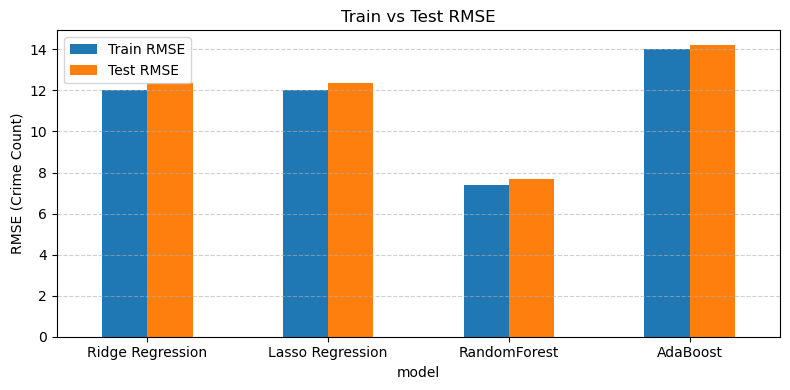


Ridge Regression:


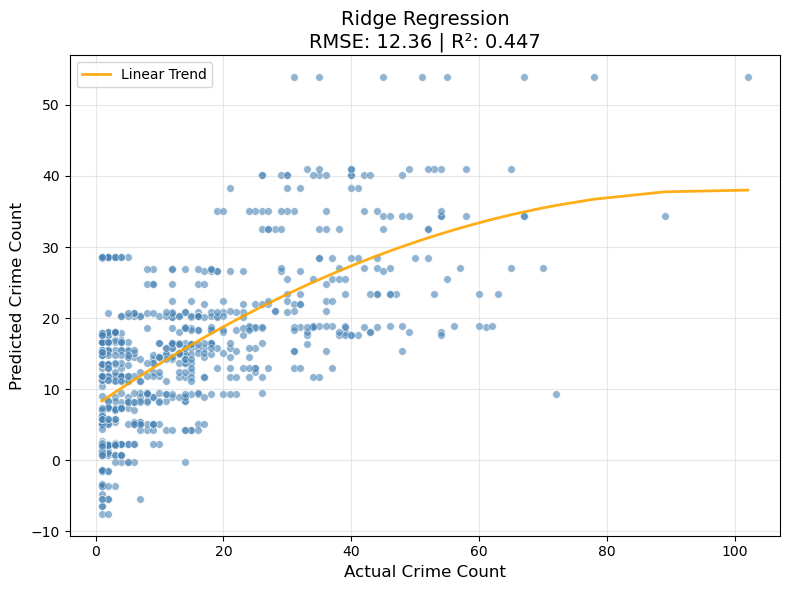

Top 25 Features:
 1. onehot__neighborhood$NORTH BEACON HILL   | +31.6134 INCREASES
 2. onehot__neighborhood$SANDPOINT           | +25.0161 INCREASES
 3. onehot__neighborhood$PIONEER SQUARE      | +22.0456 INCREASES
 4. onehot__sector$W                         | -20.3950 DECREASES
 5. onehot__neighborhood$ROXHILL/WESTWOOD/ARBOR HEIGHTS | +20.3642 INCREASES
 6. onehot__neighborhood$LAKEWOOD/SEWARD PARK | -18.1398 DECREASES
 7. onehot__neighborhood$ROOSEVELT/RAVENNA   | -17.8171 DECREASES
 8. onehot__neighborhood$MILLER PARK         | -17.7151 DECREASES
 9. onehot__sector$G                         | +16.0787 INCREASES
10. onehot__neighborhood$COLUMBIA CITY       | -15.4733 DECREASES
11. onehot__neighborhood$DOWNTOWN COMMERCIAL | -14.0214 DECREASES
12. onehot__neighborhood$HIGHLAND PARK       | +13.9390 INCREASES
13. onehot__neighborhood$NORTH DELRIDGE      | +13.8513 INCREASES
14. onehot__neighborhood$JUDKINS PARK/NORTH BEACON HILL | -13.3039 DECREASES
15. onehot__precinct$Southwest      

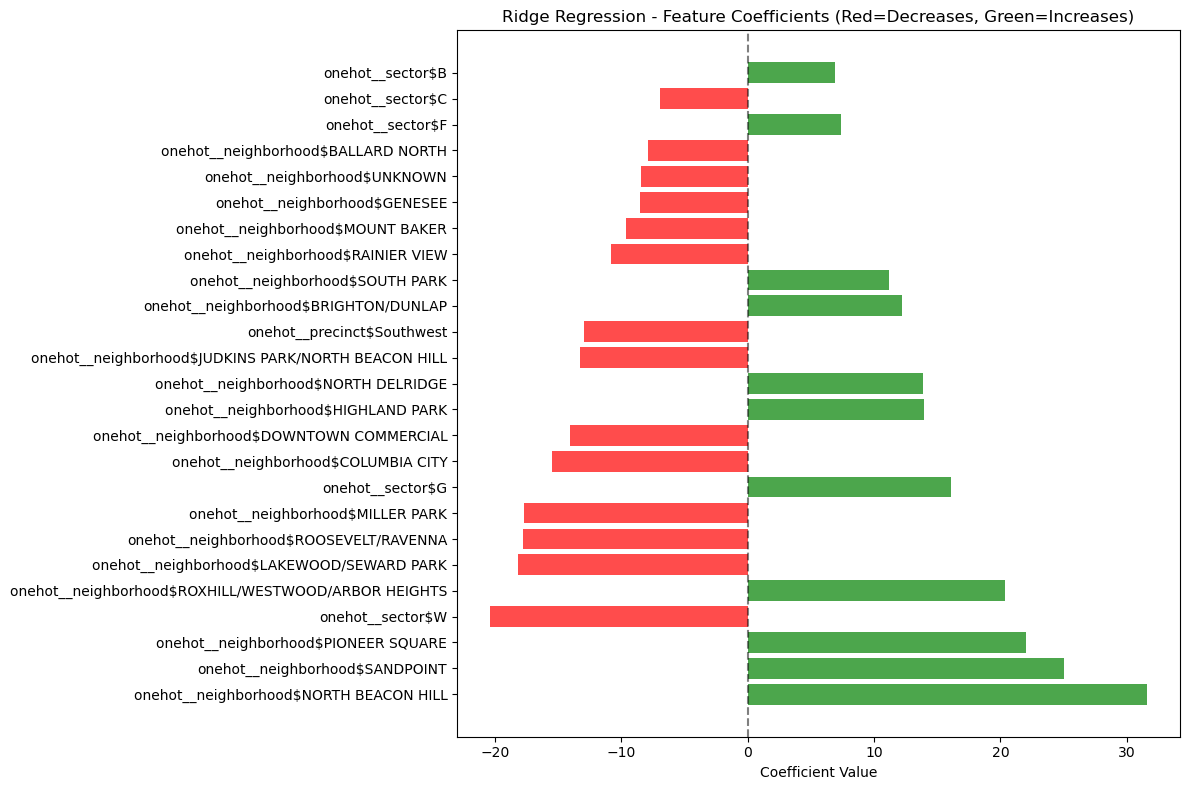


Lasso Regression:


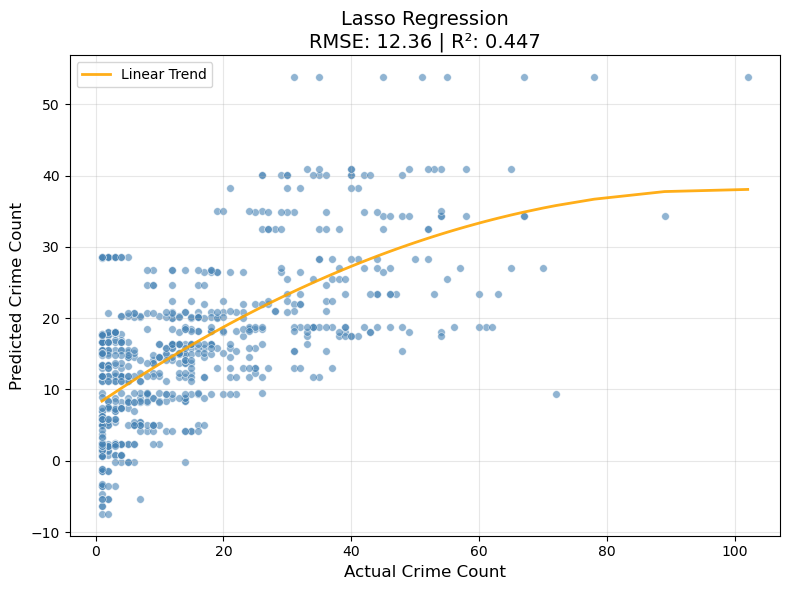

Top 25 Features:
 1. onehot__neighborhood$NORTH BEACON HILL   | +37.2021 INCREASES
 2. onehot__neighborhood$PIONEER SQUARE      | +28.3615 INCREASES
 3. onehot__sector$W                         | -27.6191 DECREASES
 4. onehot__neighborhood$SANDPOINT           | +25.2734 INCREASES
 5. onehot__sector$G                         | +19.2510 INCREASES
 6. onehot__neighborhood$ROXHILL/WESTWOOD/ARBOR HEIGHTS | +17.5134 INCREASES
 7. onehot__neighborhood$ROOSEVELT/RAVENNA   | -16.9647 DECREASES
 8. onehot__neighborhood$WALLINGFORD         | +15.0256 INCREASES
 9. onehot__neighborhood$QUEEN ANNE          | +13.5802 INCREASES
10. onehot__neighborhood$MILLER PARK         | -12.9950 DECREASES
11. onehot__neighborhood$BRIGHTON/DUNLAP     | +12.8874 INCREASES
12. onehot__neighborhood$LAKEWOOD/SEWARD PARK | -11.5413 DECREASES
13. onehot__neighborhood$JUDKINS PARK/NORTH BEACON HILL | -11.2464 DECREASES
14. onehot__neighborhood$HIGHLAND PARK       | +11.1333 INCREASES
15. onehot__neighborhood$NORTH DELRI

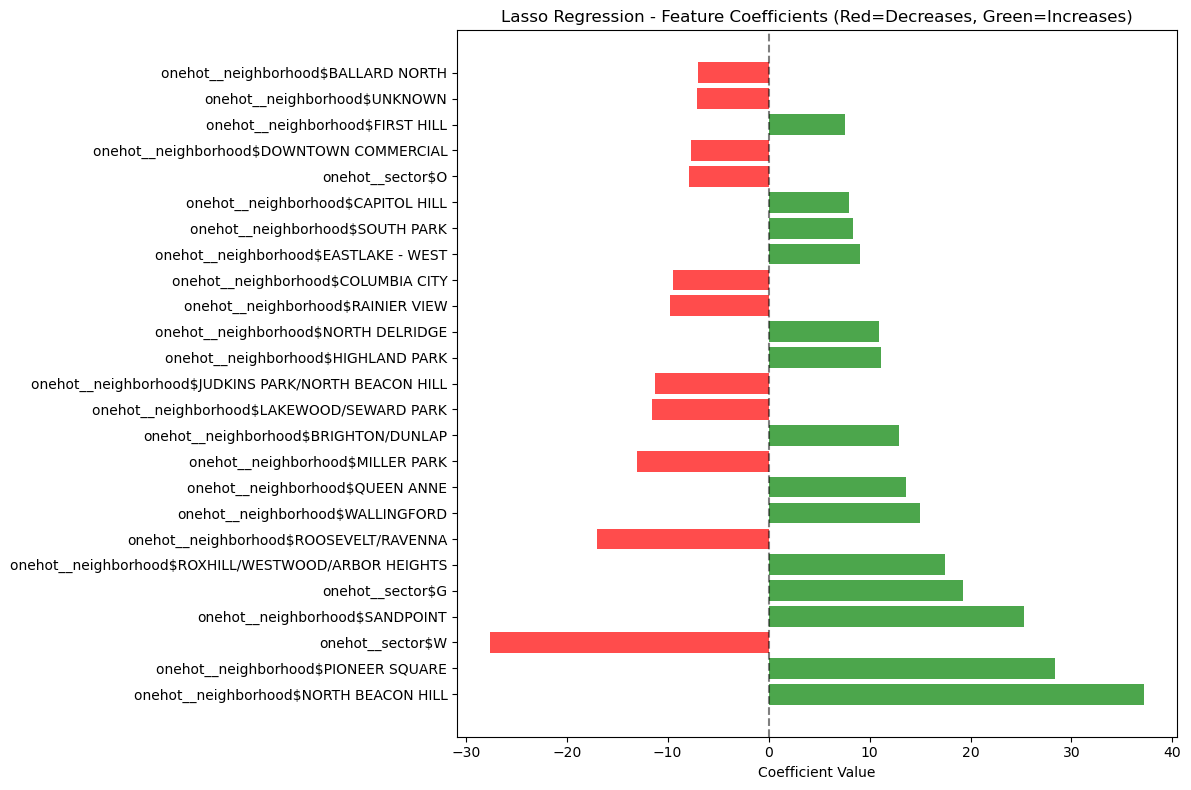


RandomForest:


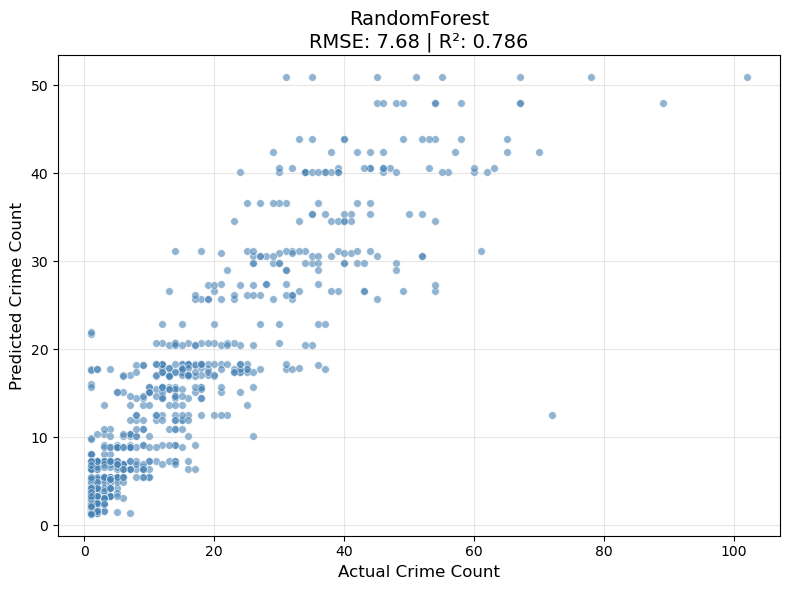

Top 25 Features:
 1. ordinal__median_household_income_bin     | 0.0929
 2. ordinal__total_population_bin            | 0.0803
 3. ordinal__median_home_value_bin           | 0.0533
 4. onehot__neighborhood$PIONEER SQUARE      | 0.0503
 5. onehot__neighborhood$NORTH BEACON HILL   | 0.0488
 6. onehot__neighborhood$HIGHLAND PARK       | 0.0395
 7. onehot__sector$G                         | 0.0363
 8. ordinal__black_bin                       | 0.0347
 9. onehot__neighborhood$DOWNTOWN COMMERCIAL | 0.0330
10. ordinal__hispanic_bin                    | 0.0317
11. onehot__neighborhood$FIRST HILL          | 0.0296
12. ordinal__asian_bin                       | 0.0256
13. onehot__neighborhood$SOUTH PARK          | 0.0243
14. onehot__neighborhood$CHINATOWN/INTERNATIONAL DISTRICT | 0.0201
15. onehot__neighborhood$SOUTH DELRIDGE      | 0.0200
16. onehot__sector$F                         | 0.0180
17. onehot__sector$E                         | 0.0179
18. onehot__sector$99                        | 0.017

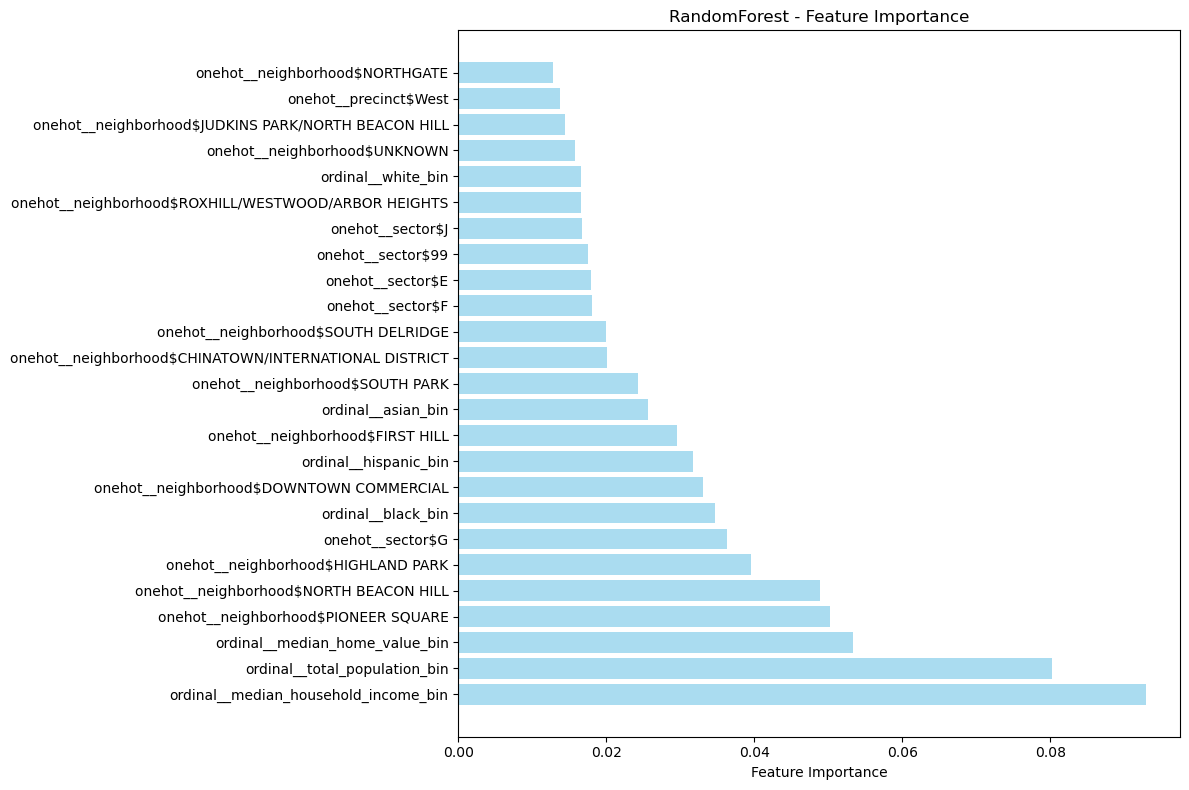


AdaBoost:


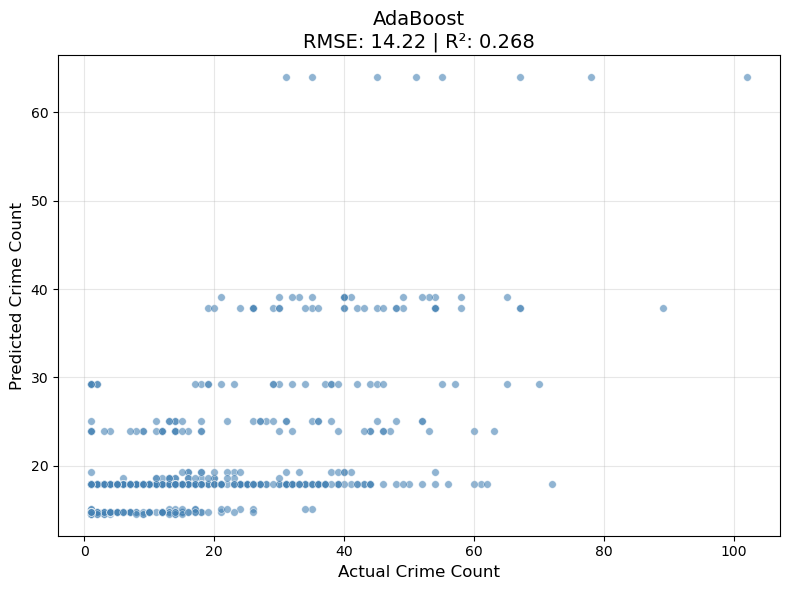

Top 25 Features:
 1. onehot__neighborhood$PIONEER SQUARE      | 0.3270
 2. ordinal__total_population_bin            | 0.1405
 3. onehot__neighborhood$NORTH BEACON HILL   | 0.1245
 4. onehot__sector$G                         | 0.0934
 5. ordinal__median_household_income_bin     | 0.0594
 6. onehot__neighborhood$UNKNOWN             | 0.0441
 7. onehot__neighborhood$JUDKINS PARK/NORTH BEACON HILL | 0.0427
 8. ordinal__black_bin                       | 0.0411
 9. onehot__neighborhood$FIRST HILL          | 0.0346
10. onehot__neighborhood$DOWNTOWN COMMERCIAL | 0.0330
11. onehot__neighborhood$HIGHLAND PARK       | 0.0280
12. onehot__sector$B                         | 0.0206
13. onehot__neighborhood$BRIGHTON/DUNLAP     | 0.0109
14. onehot__neighborhood$UNIVERSITY          | 0.0000
15. onehot__neighborhood$SOUTH PARK          | 0.0000
16. onehot__neighborhood$WALLINGFORD         | 0.0000
17. onehot__precinct$East                    | 0.0000
18. onehot__neighborhood$SOUTH DELRIDGE      | 0.0000


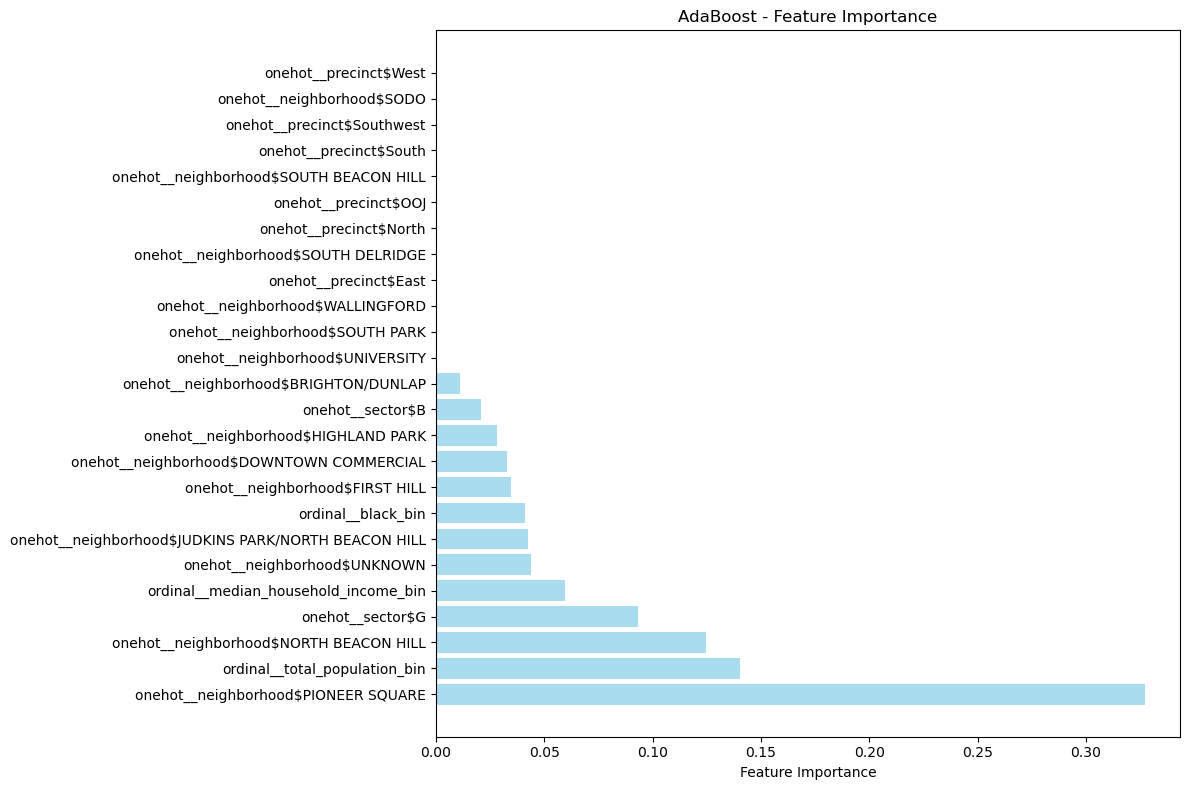


COMPREHENSIVE MODEL COMPARISON TABLE
                  rmse_train  rmse_test     r2     mae  overfitting
RandomForest           7.381      7.682  0.786   4.997        0.301
Ridge Regression      12.036     12.356  0.447   9.044        0.320
Lasso Regression      12.038     12.357  0.447   9.053        0.319
AdaBoost              14.019     14.218  0.268  11.974        0.199

BEST MODEL SUMMARY
Best Model: RandomForest
Test RMSE: 7.682 crimes
R² Score: 0.786 (78.6% variance explained)
MAE: 4.997 crimes
Overfitting: 0.301


In [12]:
# ===========================
# MODELS ANALYSIS
# ===========================

def plot_rmse_comparison(results, figsize=(8, 4), title='Train vs Test RMSE'):
    """Plot comparison of training vs test RMSE for models."""
    rmse_df = pd.DataFrame(results)
    rmse_df = rmse_df.rename(columns={"rmse_train": "Train RMSE", "rmse_test": "Test RMSE"})
    rmse_df = rmse_df.set_index("model")[["Train RMSE", "Test RMSE"]]

    ax = rmse_df.plot(kind='bar', figsize=figsize, title=title)
    plt.ylabel("RMSE (Crime Count)")
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_actual_vs_predicted(y_true, y_pred, model_name):
    """Plot actual vs predicted values with appropriate visualization for model type."""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, s=30, color='steelblue', edgecolors='white', linewidth=0.5)

    # Add trend line only for linear models using poly_degree=1
    if 'Regression' in model_name:  # Ridge Regression, Lasso Regression
        unique_y_true = np.unique(y_true)
        if len(unique_y_true) > 1:
            # Use linear trend line (poly_degree=1) for regression models
            trend_line = np.poly1d(np.polyfit(y_true, y_pred, poly_degree))(unique_y_true)
            plt.plot(unique_y_true, trend_line, 'orange', linewidth=2, 
                    label='Linear Trend', alpha=0.9)

    # Calculate and display metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    plt.xlabel('Actual Crime Count', fontsize=12)
    plt.ylabel('Predicted Crime Count', fontsize=12)
    plt.title(f'{model_name}\nRMSE: {rmse:.2f} | R²: {r2:.3f}', fontsize=14)
    
    # Only show legend if there's a trend line
    if 'Regression' in model_name:
        plt.legend()
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return rmse, r2

def plot_feature_importance(feature_df, model_name, top_k=50):
    """Plot horizontal bar chart of feature importance with direction."""
    plt.figure(figsize=(12, 8))
    
    if 'coefficient' in feature_df.columns:
        # Linear models - show actual coefficients with direction
        top_features = feature_df.head(top_k)
        colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]
        
        plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Coefficient Value')
        plt.title(f'{model_name} - Feature Coefficients (Red=Decreases, Green=Increases)')
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        
    else:
        # Tree models - show importance only
        top_features = feature_df.head(top_k)
        plt.barh(range(len(top_features)), top_features['importance'], color='skyblue', alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'{model_name} - Feature Importance')
    
    plt.tight_layout()
    plt.show()
    plt.close()

def comprehensive_analysis(predictions):
    """Complete analysis of all models."""
    
    # 1. Performance comparison
    results = []
    detailed_metrics = {}
    
    for model_name, pred_data in predictions.items():
        y_true = pred_data["y_test_true"]
        y_pred = pred_data["y_test_pred"]
        
        # Calculate additional metrics
        rmse_test = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        mae = np.mean(np.abs(y_true - y_pred))
        
        results.append({
            "model": model_name,
            "rmse_train": pred_data["rmse_train"],
            "rmse_test": pred_data["rmse_test"]
        })
        
        detailed_metrics[model_name] = {
            'rmse_train': pred_data["rmse_train"],
            'rmse_test': rmse_test,
            'r2': r2,
            'mae': mae,
            'overfitting': rmse_test - pred_data["rmse_train"]
        }
    
    # Display basic performance table
    rmse_df = pd.DataFrame(results).set_index("model")
    rmse_df['overfitting'] = rmse_df['rmse_test'] - rmse_df['rmse_train']
    print("Model Performance Summary:")
    print(rmse_df.round(3))
    
    # Plot RMSE comparison
    plot_rmse_comparison(results)
    
    # 2. Actual vs Predicted plots and feature importance
    for model_name, pred_data in predictions.items():
        print(f"\n{model_name}:")
        
        # Performance plot
        plot_actual_vs_predicted(pred_data["y_test_true"], pred_data["y_test_pred"], model_name)
        
        # Feature importance
        pipeline = pred_data["pipe"]
        regressor = pipeline.named_steps['regressor']
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
        top_features_count = 25
        if hasattr(regressor, 'coef_'):
            # Linear models
            coefficients = regressor.coef_
            feature_df = pd.DataFrame({
                'feature': feature_names,
                'coefficient': coefficients,
                'abs_coefficient': np.abs(coefficients)
            }).sort_values('abs_coefficient', ascending=False)

            print(f"Top {top_features_count} Features:")
            for i, (_, row) in enumerate(feature_df.head(top_features_count).iterrows()):
                direction = "INCREASES" if row['coefficient'] > 0 else "DECREASES"
                print(f"{i+1:2d}. {row['feature']:<40} | {row['coefficient']:+8.4f} {direction}")

            plot_feature_importance(feature_df, model_name, top_features_count)

        elif hasattr(regressor, 'feature_importances_'):
            # Tree models
            importances = regressor.feature_importances_
            feature_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            print(f"Top {top_features_count} Features:")
            for i, (_, row) in enumerate(feature_df.head(top_features_count).iterrows()):
                print(f"{i+1:2d}. {row['feature']:<40} | {row['importance']:.4f}")

            plot_feature_importance(feature_df, model_name, top_features_count)

    # 3. Create comprehensive comparison table
    print(f"\n{'='*80}")
    print("COMPREHENSIVE MODEL COMPARISON TABLE")
    print(f"{'='*80}")
    
    comparison_df = pd.DataFrame(detailed_metrics).T
    comparison_df = comparison_df.round(3)
    
    # Sort by test RMSE (best first)
    comparison_df = comparison_df.sort_values('rmse_test')
    
    print(comparison_df)
    
    # 4. Best model summary
    best_model_name = comparison_df.index[0]
    best_metrics = comparison_df.loc[best_model_name]
    
    print(f"\n{'='*60}")
    print("BEST MODEL SUMMARY")
    print(f"{'='*60}")
    print(f"Best Model: {best_model_name}")
    print(f"Test RMSE: {best_metrics['rmse_test']:.3f} crimes")
    print(f"R² Score: {best_metrics['r2']:.3f} ({best_metrics['r2']*100:.1f}% variance explained)")
    print(f"MAE: {best_metrics['mae']:.3f} crimes")
    print(f"Overfitting: {best_metrics['overfitting']:.3f}")
    
    return comparison_df

# Execute analysis
analysis_results = comprehensive_analysis(predictions)

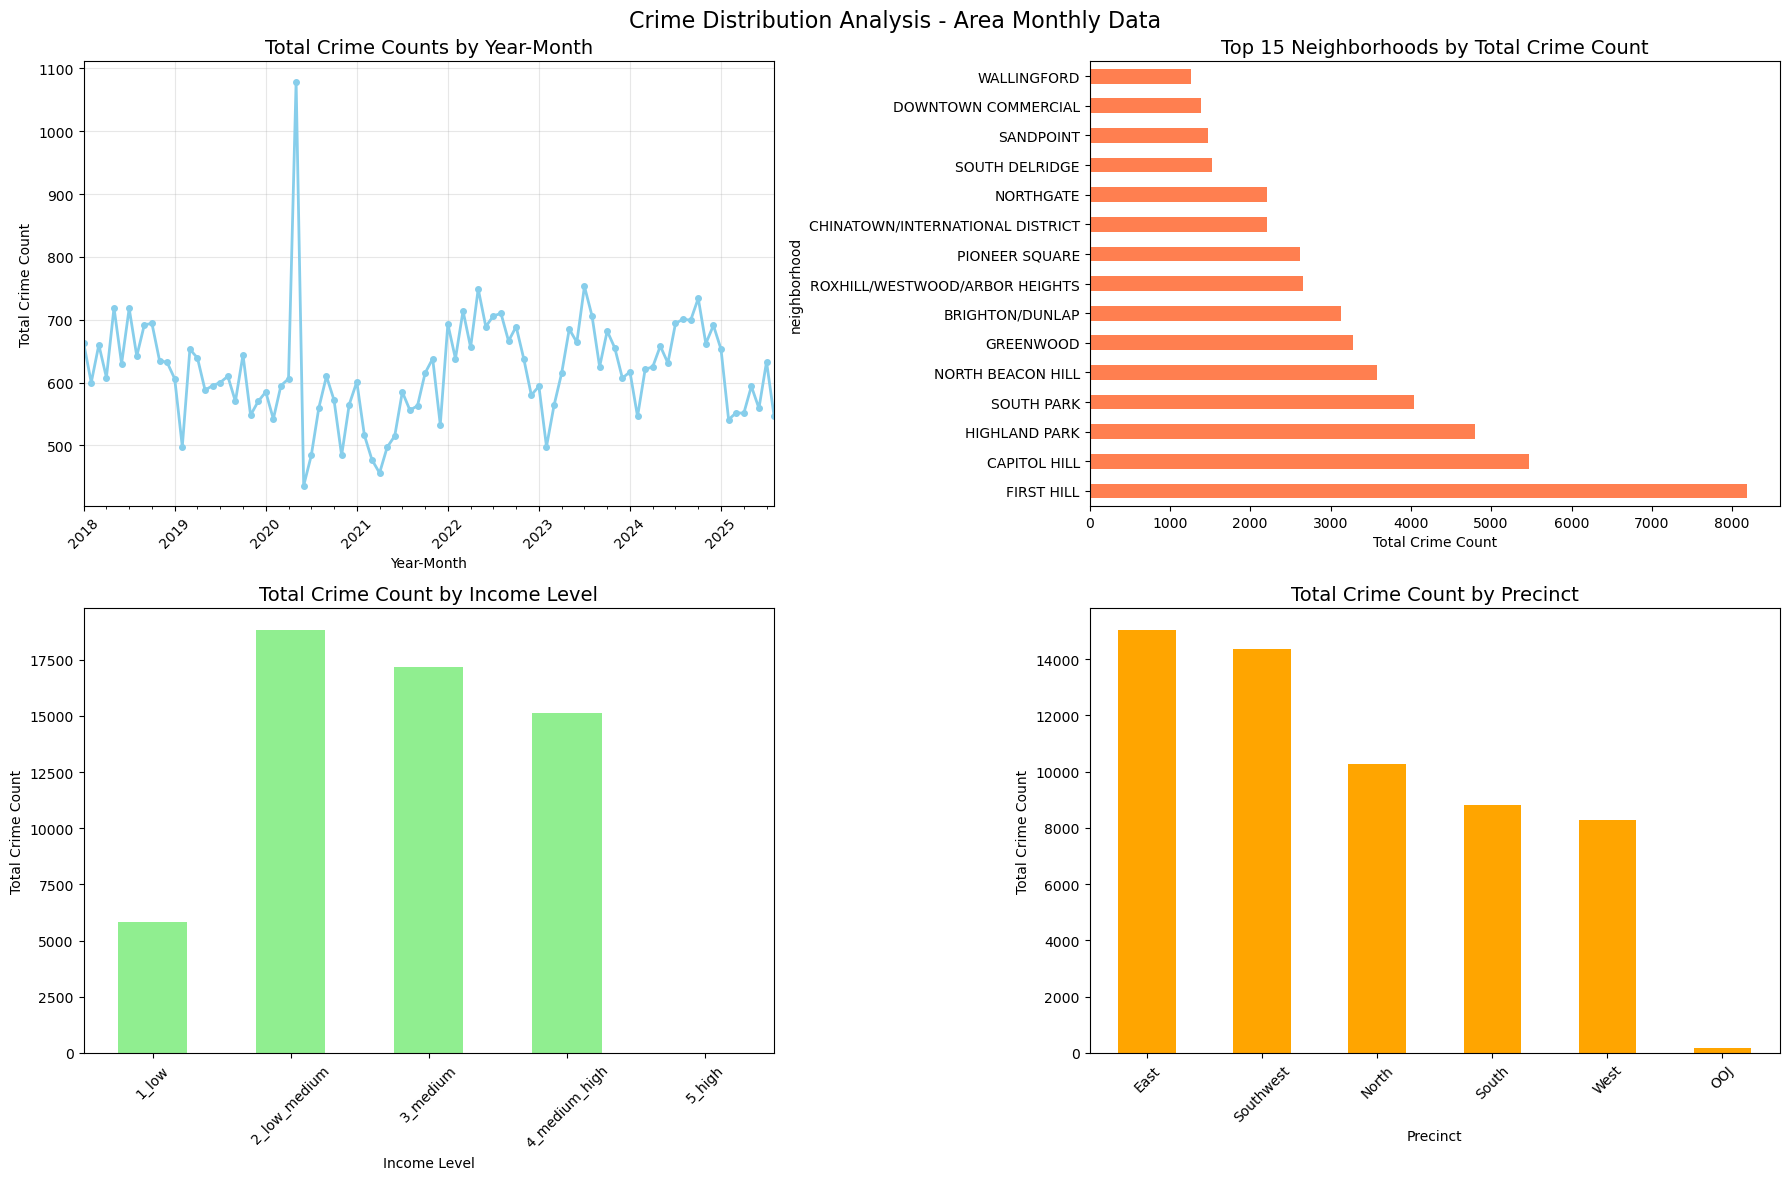

In [13]:
# 1. Crime Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Crime Distribution Analysis - Area Monthly Data', fontsize=16, y=0.98)

# Crime count distribution
ax1 = axes[0, 0]
monthly_totals = area_monthly_crimes.groupby('offense_year_month')['crime_count'].sum().sort_index()
monthly_totals.plot(ax=ax1, color='skyblue', linewidth=2, marker='o', markersize=4)
ax1.set_title('Total Crime Counts by Year-Month', fontsize=14)
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Total Crime Count')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Top neighborhoods by total crime
ax2 = axes[0, 1]
neighborhood_totals = area_monthly_crimes.groupby('neighborhood')['crime_count'].sum().sort_values(ascending=False).head(15)
neighborhood_totals.plot(kind='barh', ax=ax2, color='coral')
ax2.set_title('Top 15 Neighborhoods by Total Crime Count', fontsize=14)
ax2.set_xlabel('Total Crime Count')

# Crime by income level
ax3 = axes[1, 0]
income_totals = area_monthly_crimes.groupby('median_household_income_bin')['crime_count'].sum().sort_index()
income_totals.plot(kind='bar', ax=ax3, color='lightgreen')
ax3.set_title('Total Crime Count by Income Level', fontsize=14)
ax3.set_xlabel('Income Level')
ax3.set_ylabel('Total Crime Count')
ax3.tick_params(axis='x', rotation=45)

# Crime by precinct
ax4 = axes[1, 1]
precinct_totals = area_monthly_crimes.groupby('precinct')['crime_count'].sum().sort_values(ascending=False)
precinct_totals.plot(kind='bar', ax=ax4, color='orange')
ax4.set_title('Total Crime Count by Precinct', fontsize=14)
ax4.set_xlabel('Precinct')
ax4.set_ylabel('Total Crime Count')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Key Factors Affecting Crime Count in Seattle

## Executive Summary

Based on comprehensive machine learning analysis using Ridge Regression, Lasso Regression, RandomForest, and AdaBoost models, several key factors significantly influence crime counts in Seattle neighborhoods. The **RandomForest model achieved the best performance** with **78.3% variance explained** (R² = 0.783, RMSE = 7.72 crimes), indicating these factors are highly predictive of crime patterns.

---

## Primary Crime Drivers (Consistently High Impact Across All Models)

### 1. Geographic Hotspots - Specific Neighborhoods
**High Crime Areas:**
- **North Beacon Hill** - Consistently the strongest predictor (+34-36 crime increase)
- **Pioneer Square** - Major crime hotspot (+21-29 crime increase)  
- **Highland Park** - Significant crime concentration (high importance in tree models)
- **First Hill** - Notable crime activity (high RandomForest importance)

**Low Crime Areas:**
- **Roosevelt/Ravenna** - Strong crime reduction effect (-19 crimes)
- **Lakewood/Seward Park** - Lower crime rates (-19-20 crimes)
- **Miller Park** - Reduced crime activity (-16-21 crimes)
- **Belltown** - Lower than expected crime rates (-10-11 crimes)

### 2. Demographic Composition Effects

**Hispanic Population Distribution:**
- **High Hispanic concentration** areas: **+21-26 more crimes**
- **Low Hispanic concentration** areas: **-11 fewer crimes**

**Asian Population Patterns:**
- **Asian concentration levels**: **Key predictor** (3.1% importance in RandomForest)
- **High Asian concentration** areas: **+13-20 more crimes**
- **Medium Asian concentration**: Moderate crime increases

**Note:** *Ordinal encoding of demographic categories has significantly improved the model's ability to capture hierarchical relationships in population distributions, enhancing predictive accuracy.*

### 3. Socioeconomic Indicators

**Income Effects:**
- **Household income levels**: **Top predictor** in RandomForest model (8.7% importance)
- **Medium-high household income** areas: **-8 to -9 fewer crimes**
- **Lower income areas**: Associated with higher crime rates

**Population Density:**
- **Population distribution**: **Second highest predictor** (7.1% importance)
- Critical factor for resource allocation and patrol planning

**Housing Market Indicators:**
- **Home value levels**: **Fourth highest predictor** (5.1% importance) 
- **Low-medium home values**: **+8 more crimes** (economic stress indicators)
- **Higher home values**: Generally associated with lower crime

---

## Geographic and Administrative Factors

### Police Sectors (Administrative Zones)
**High Crime Sectors:**
- **Sector G**: **+15-20 more crimes** (consistent across models)
- **Sector F**: **+8 more crimes**

**Low Crime Sectors:**
- **Sector W**: **-17 to -26 fewer crimes** (most effective policing)
- **Sector M**: **-13 fewer crimes**

### Police Precincts
- **Southwest Precinct**: **-10 fewer crimes** (effective crime prevention)
- **East Precinct**: Variable effects across models

---

## Actionable Insights for Law Enforcement

### Resource Allocation Priorities
1. **Focus patrol resources** on North Beacon Hill and Pioneer Square
2. **Enhance community policing** in high Hispanic concentration areas (address underlying socioeconomic issues)
3. **Study and replicate** successful strategies from Sector W and Southwest Precinct
4. **Monitor population density changes** as early warning indicators

### Prevention Strategies
1. **Target socioeconomic interventions** in low-income, high-crime neighborhoods
2. **Implement community programs** in areas with low-medium home values
3. **Coordinate with social services** in demographically high-risk areas
4. **Optimize patrol scheduling** based on population density patterns

### Performance Monitoring (Enhanced Accuracy)
1. **Track crime trends** in the identified hotspot neighborhoods monthly
2. **Monitor effectiveness** of interventions using the established baseline predictions
3. **Use RandomForest model** for monthly crime forecasting (**78.3% accuracy** - highly reliable)
4. **Adjust resource allocation** based on changing demographic patterns
5. **Leverage ordinal feature insights** for more nuanced socioeconomic trend analysis

---

**This analysis provides a data-driven foundation for evidence-based policing strategies and resource allocation decisions in Seattle.**